# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster

In [2]:
# packageroot = Path('../../').resolve()
packageroot = Path('../../').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

/Users/josephdong/PyEEG


/Users/josephdong/PyEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer']


In [3]:
tempdir = Path('../../tmp').resolve()
print(tempdir)
core.set_temp_directory(tempdir)

/Users/josephdong/PyEEG/tmp


In [4]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

/Users/josephdong/PyEEG/pythoneeg/core/core.py:153: UserWarning: truncate = True. Only the first 3 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")


In [5]:
Path('./test-wars/A5').resolve()

PosixPath('/Users/josephdong/PyEEG/notebooks/tests/test-wars/A5')

In [6]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()


In [7]:
cluster = LocalCluster()
display(cluster)

2025-03-27 14:13:25,238 - DEBUG - Using selector: KqueueSelector


LocalCluster(5b9c3f2c, 'tcp://127.0.0.1:52253', workers=11, threads=11, memory=36.00 GiB)

In [8]:
# %%script true
# animal_ids = ['A5', 'A10', 'F22', 'G25', 'G26', 'N21', 'N22', 'N23', 'N24', 'N25']
# animal_ids = ['A5']
animal_ids = ['A10']
# animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=False)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec() # parallelization breaks if not enough memory

    # with Client(cluster) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running war")
    #     ao.convert_rowbins_to_rec(multiprocess_mode='dask') # paralleization breaks if not enough memory
    #     war = ao.compute_windowed_analysis(['all'], multiprocess_mode='dask')
    #     war.save_pickle_and_json(Path(f'./test-wars-full/{animal_id}').resolve())

    # with Client(cluster) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running sar")
    #     sar = ao.compute_spike_analysis(multiprocess_mode='dask')

Converting column bins to row bins:   0%|          | 0/1 [00:00<?, ?it/s]

2025-03-27 14:13:26,324 - WARNING - Row-major binary files already exist! Skipping existing files


Converting row bins to recs: 100%|██████████| 1/1 [00:00<00:00, 22.94it/s]


In [9]:
war = visualization.WindowAnalysisResult.load_pickle_and_json(Path('./test-wars/F22').resolve())

2025-03-27 14:13:26,383 - WARNING - Intan Input (1)/PortD D-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,383 - WARNING - Intan Input (1)/PortD D-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,383 - WARNING - Intan Input (1)/PortD D-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,383 - WARNING - Intan Input (1)/PortD D-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,384 - WARNING - Intan Input (1)/PortD D-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,384 - WARNING - Intan Input (1)/PortD D-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,384 - WARNING - Intan Input (1)/PortD D-017 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,384 - WARNING - Intan

In [10]:
war.get_result(['all'], allow_missing=True).head(3)

,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,ampvar,psd,psdtotal,psdband,psdslope,cohere,pcorr
0,0,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:13.560,True,"[324.54126, 123.114975, 89.73863, 199.99384, 3...","[98233.96, 14860.108, 7970.6455, 37275.63, 151...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[2990.8171, 9656.856, 4898.069, 6713.2295, 427...","{'delta': [2371.017, 3296.126, 1211.0659, 2644...","[(-1.6245375548094994, 3.0368814205586463), (-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:17.560,True,"[33.98205, 98.85395, 73.50662, 72.37029, 407.4...","[1154.7555, 9768.596, 5399.9824, 5234.5786, 16...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[617.85815, 8765.923, 4538.3516, 4057.7214, 14...","{'delta': [190.04459, 1800.4429, 548.10364, 11...","[(-1.2709592689560614, 2.4014942712763423), (-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:21.560,True,"[39.47052, 100.149216, 70.8411, 86.555595, 620...","[1557.7693, 10023.685, 5018.3926, 7481.013, 38...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[808.93463, 7760.562, 3900.8845, 4248.7896, 79...","{'delta': [306.9735, 2821.0764, 938.7143, 2116...","[(-1.4739850325245956, 2.662434533055389), (-1...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


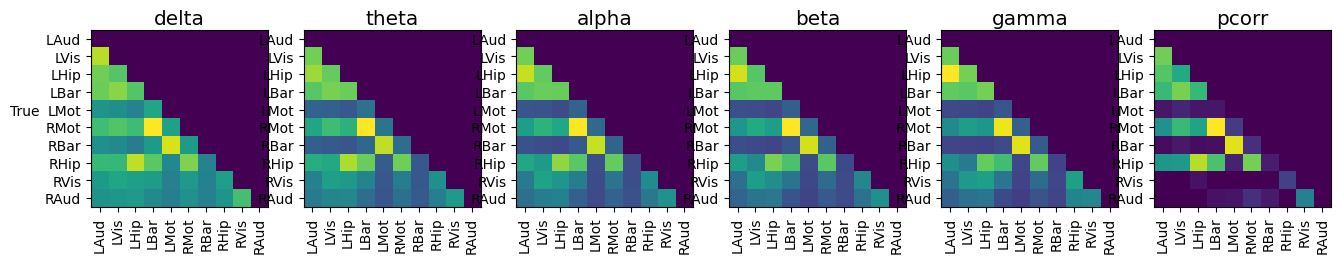

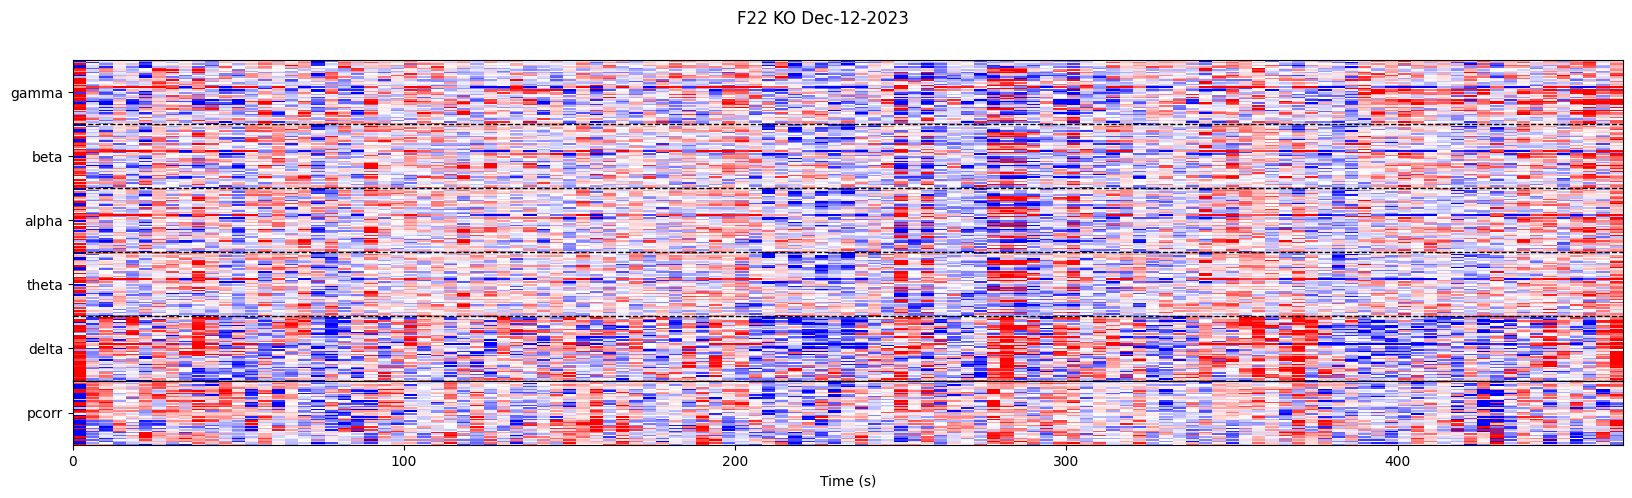

/Users/josephdong/PyEEG/pythoneeg/visualization/plotting/animal.py:325: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10**(b + m * np.log10(freqs)), c=f'C{j}', alpha=0.75)


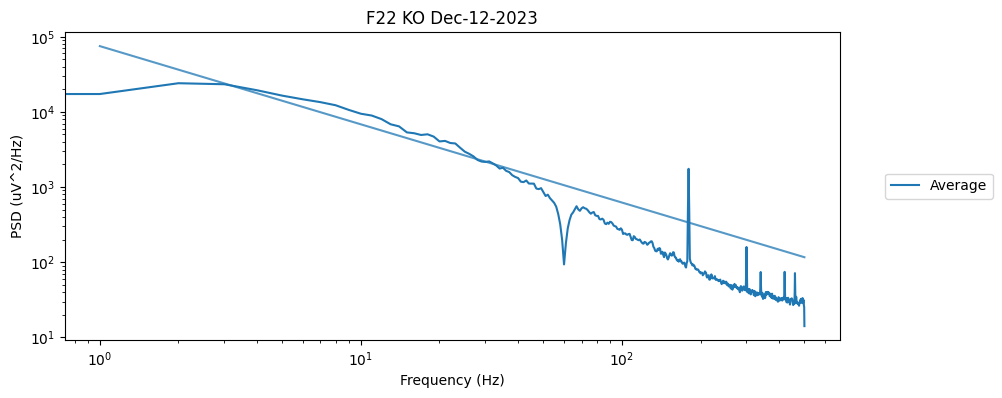

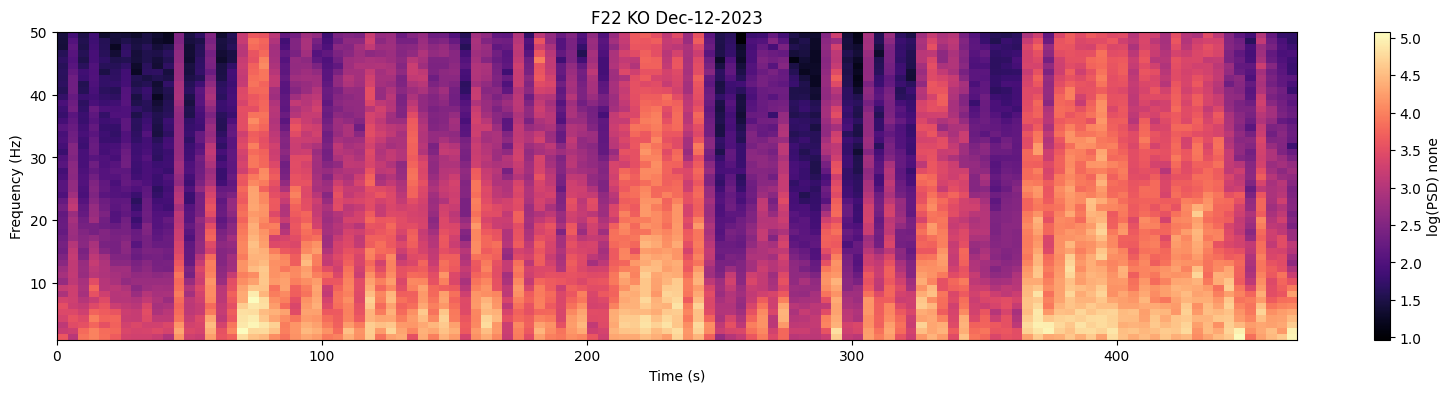

In [11]:
logger.setLevel(logging.WARNING)
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

In [12]:
logger.setLevel(logging.DEBUG)
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    # logging.critical(war.result.iloc[0]['pcorr'])
    # war = war.filter_all()
    # logging.critical(war.result.iloc[0]['pcorr'])
    wars.append(war)
ep = visualization.ExperimentPlotter(wars)


2025-03-27 14:13:26,991 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,992 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,992 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,992 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,992 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,992 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,993 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:26,993 - WARNING - Intan

2025-03-27 14:13:27,004 - INFO - pulling rms
2025-03-27 14:13:27,005 - DEBUG - groups: ['A10', 'F22']
2025-03-27 14:13:27,005 - DEBUG - vals.shape: (31, 10)
2025-03-27 14:13:27,006 - DEBUG - vals.shape: (117, 10)
2025-03-27 14:13:27,218 - INFO - pulling ampvar
2025-03-27 14:13:27,221 - DEBUG - groups: ['A10', 'F22']
2025-03-27 14:13:27,221 - DEBUG - vals.shape: (31, 10)
2025-03-27 14:13:27,222 - DEBUG - vals.shape: (117, 10)
2025-03-27 14:13:27,358 - INFO - pulling psdtotal
2025-03-27 14:13:27,358 - DEBUG - groups: ['A10', 'F22']
2025-03-27 14:13:27,359 - DEBUG - vals.shape: (31, 10)
2025-03-27 14:13:27,359 - DEBUG - vals.shape: (117, 10)
2025-03-27 14:13:27,490 - INFO - pulling psdslope
2025-03-27 14:13:27,490 - DEBUG - groups: ['A10', 'F22']
2025-03-27 14:13:27,491 - DEBUG - vals.shape: (31, 10, 2)
2025-03-27 14:13:27,492 - DEBUG - vals.shape: (117, 10, 2)
2025-03-27 14:13:27,651 - INFO - pulling psdband
2025-03-27 14:13:27,652 - DEBUG - groups: ['A10', 'F22']
2025-03-27 14:13:27,652

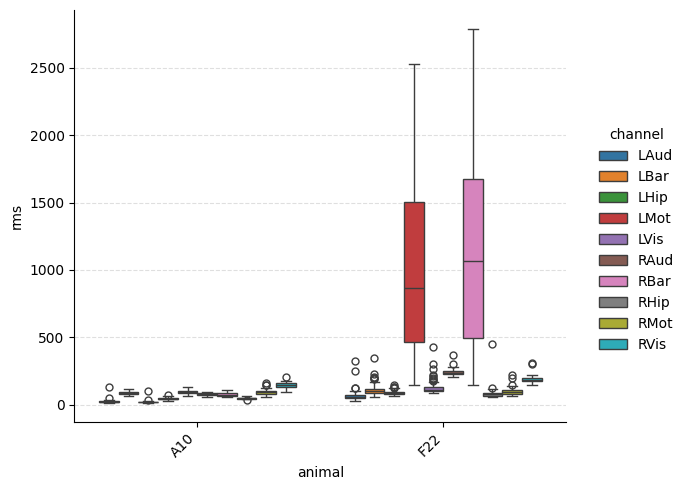

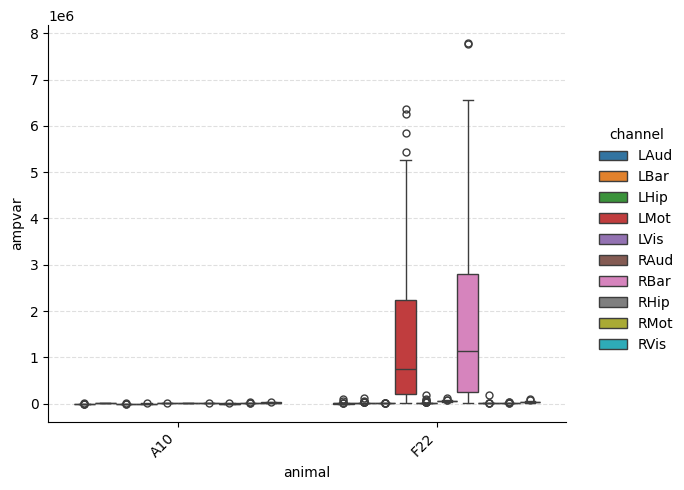

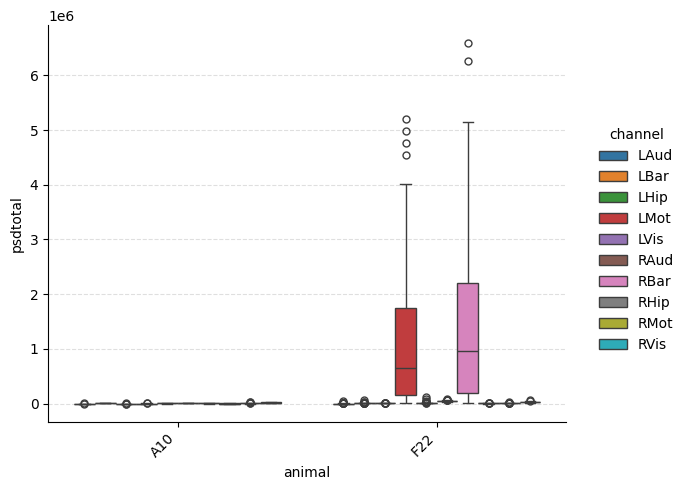

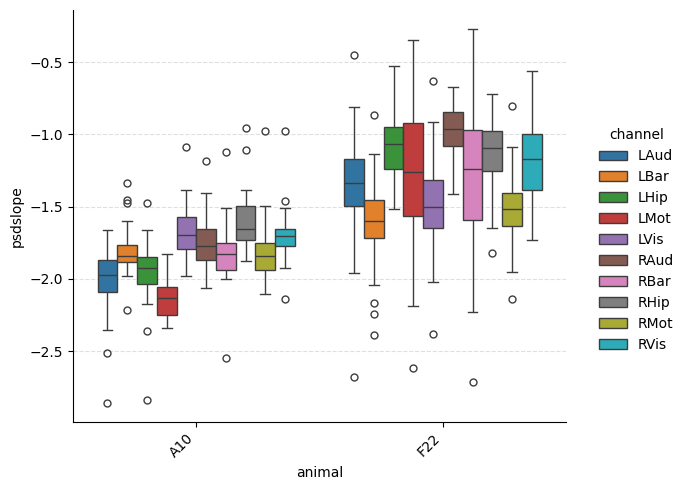

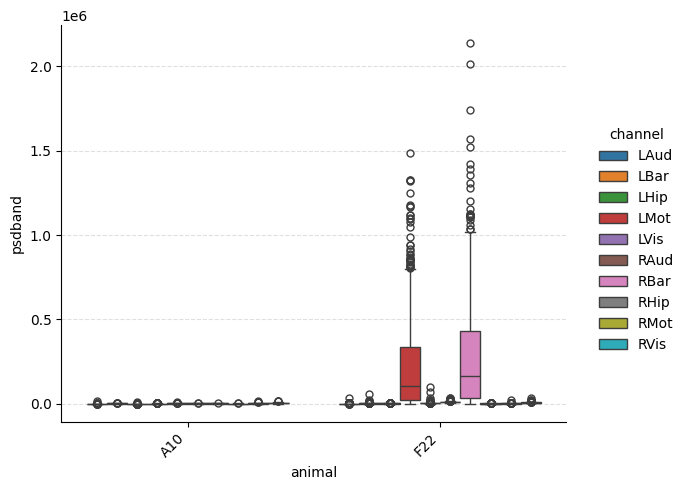

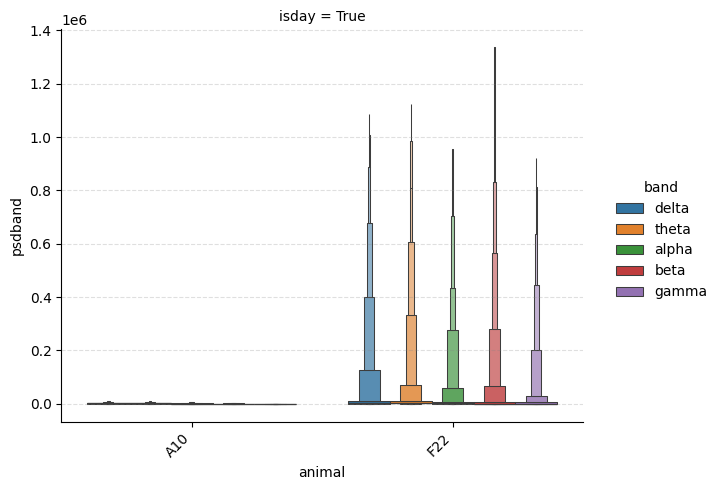

In [13]:
for feat in constants.LINEAR_FEATURE + ['psdband']:
    logging.info(f'pulling {feat}')
    # df = ep._pull_timeseries_dataframe(feat, ['genotype', 'isday'], collapse_channels=True)
    # display(df)
    # ep.plot_boxplot_2(feat, ['genotype', 'animalday'], collapse_channels=False)
    ep.plot_catplot(feat, 'animal')

ep.plot_catplot('psdband', ['animal', 'isday', 'animalday'], 
                x='animal',
                col='isday',
                hue='band',
                kind='boxen',
                collapse_channels=False,
                catplot_params={'showfliers': False})

2025-03-27 14:13:37,964 - INFO - pulling cohere
2025-03-27 14:13:37,966 - DEBUG - groups: [('A10', True), ('F22', True)]
2025-03-27 14:13:37,966 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-03-27 14:13:37,967 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-03-27 14:13:37,969 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-03-27 14:13:37,969 - DEBUG - vals.shape: (117, 5, 10, 10)


,animal,isday,channel,cohere,band
0,A10,True,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",delta
0,A10,True,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",theta
0,A10,True,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",alpha
0,A10,True,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",beta
0,A10,True,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",gamma
...,...,...,...,...,...
147,F22,True,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",delta
147,F22,True,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",theta
147,F22,True,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",alpha
147,F22,True,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",beta


2025-03-27 14:13:38,009 - DEBUG - groups: [('A10', True), ('F22', True)]
2025-03-27 14:13:38,010 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-03-27 14:13:38,011 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-03-27 14:13:38,016 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-03-27 14:13:38,017 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-03-27 14:13:38,214 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x166a249d0>
2025-03-27 14:13:38,227 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x16432d240>
2025-03-27 14:13:38,239 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x16521b250>
2025-03-27 14:13:38,251 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x167d2cd30>
2025-03-27 14:13:38,261 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x167d803d0>
2025-03-27 14:13:38,270 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x167dcef20>
2025-03-27 14:13:38,280 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x167deb430

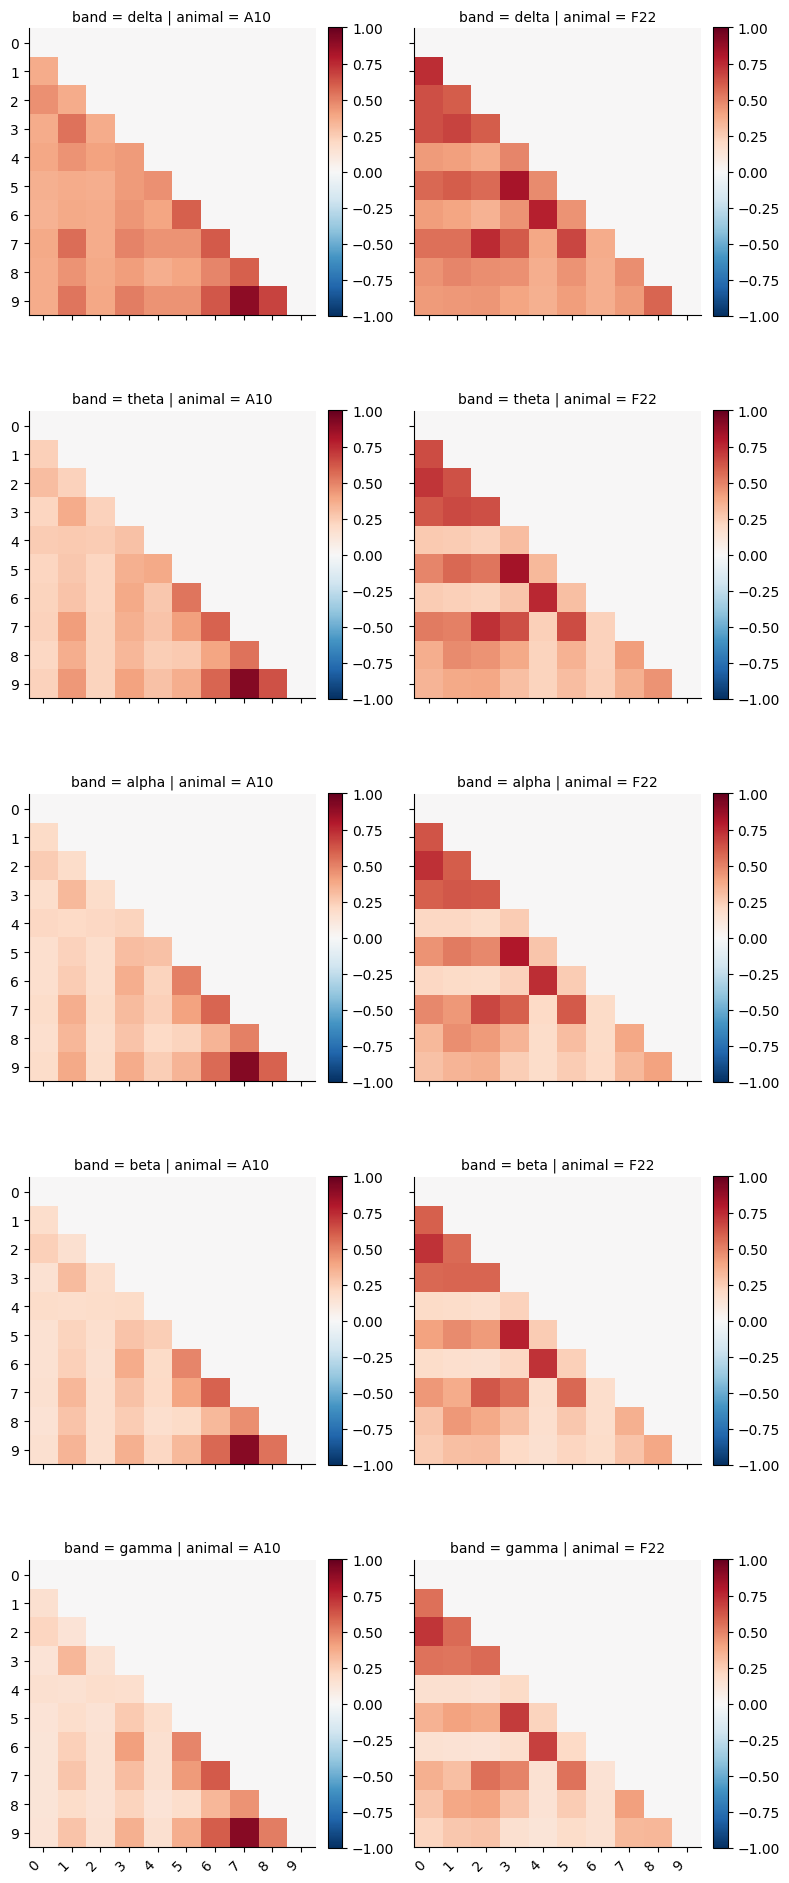

In [19]:
for feat in ['cohere']:
    logging.info(f'pulling {feat}')
    df = ep._pull_timeseries_dataframe(feat, ['animal', 'isday'])
    # display(df.iloc[0]['cohere'])
    display(df)
    ep.plot_2d_feature_2(feat, ['animal', 'isday'], row='band')


2025-03-27 14:13:29,312 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x166381a20>
2025-03-27 14:13:29,329 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x1666810c0>
2025-03-27 14:13:29,402 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x166c91e10>
2025-03-27 14:13:29,424 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x166d5ae60>
2025-03-27 14:13:29,444 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x166e06b60>
2025-03-27 14:13:29,466 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x166ec39d0>
2025-03-27 14:13:29,594 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x166aed0c0>


(<Figure size 800x1500 with 15 Axes>,
 array([[<Axes: title={'center': 'A10'}, ylabel='delta'>,
         <Axes: title={'center': 'F22'}>],
        [<Axes: ylabel='theta'>, <Axes: >],
        [<Axes: ylabel='alpha'>, <Axes: >],
        [<Axes: ylabel='beta'>, <Axes: >],
        [<Axes: ylabel='gamma'>, <Axes: >]], dtype=object),
 None)

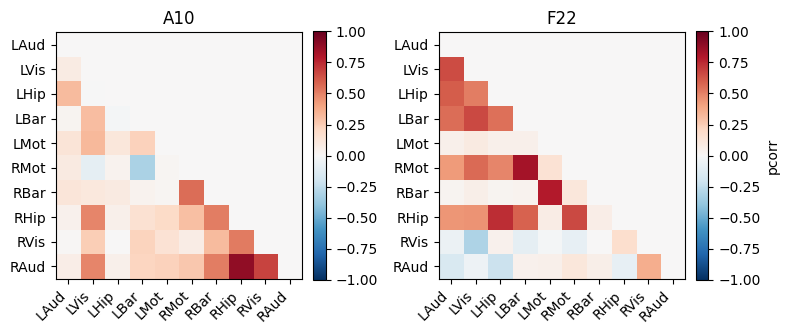

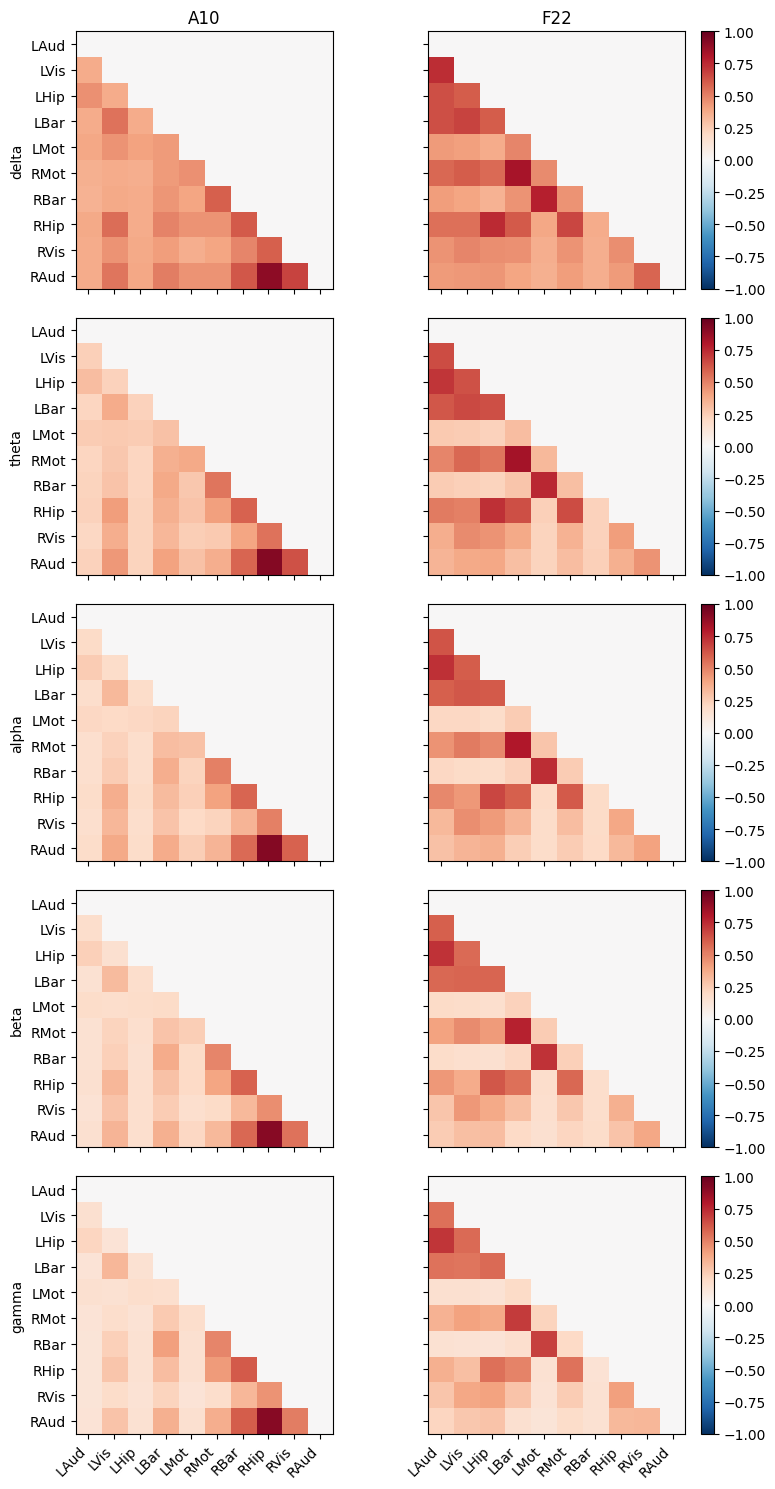

In [15]:

# ep.plot_boxplot('rms')
# ep.plot_violin('rms')
# ep.plot_scatter('rms')
ep.plot_2d_feature('pcorr', xgroup='animal')
ep.plot_2d_feature_freq('cohere', xgroup='animal')

2025-03-27 14:13:30,104 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:30,104 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:30,105 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:30,105 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:30,105 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:30,105 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:30,105 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-03-27 14:13:30,105 - WARNING - Intan

(<Figure size 800x1500 with 15 Axes>,
 array([[<Axes: title={'center': 'A10'}, ylabel='delta'>,
         <Axes: title={'center': 'F22'}>],
        [<Axes: ylabel='theta'>, <Axes: >],
        [<Axes: ylabel='alpha'>, <Axes: >],
        [<Axes: ylabel='beta'>, <Axes: >],
        [<Axes: ylabel='gamma'>, <Axes: >]], dtype=object),
 None)

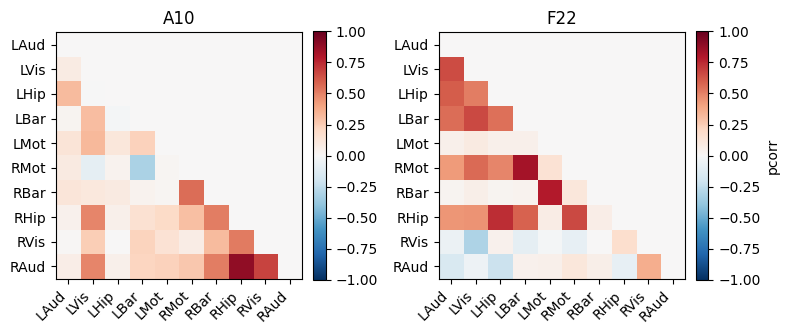

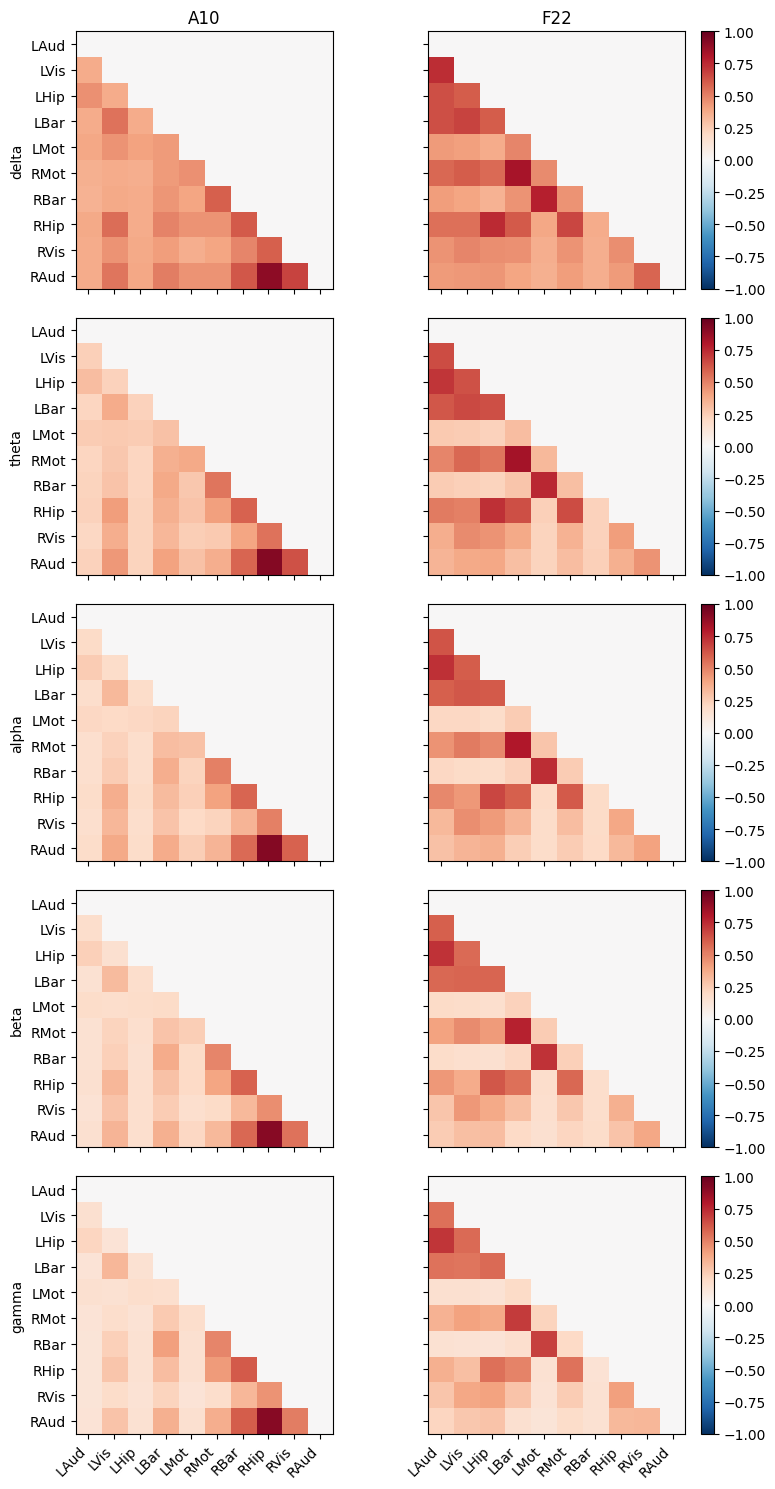

In [16]:
logger.setLevel(logging.DEBUG)
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    # logging.critical(war.result.iloc[0]['pcorr'])
    # war = war.filter_all()
    # logging.critical(war.result.iloc[0]['pcorr'])
    wars.append(war)
ep = visualization.ExperimentPlotter(wars)


# ep.plot_boxplot('rms')
# ep.plot_violin('rms')
# ep.plot_scatter('rms')
ep.plot_2d_feature('pcorr', xgroup='animal')
ep.plot_2d_feature_freq('cohere', xgroup='animal')

In [17]:
logger.setLevel(logging.DEBUG)

In [18]:
for e in sar:
    e.convert_to_mne(chunk_len=1440)
    e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve(), overwrite=True)

NameError: name 'sar' is not defined

In [17]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-mnes/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

Opening raw data file test-mnes/A5 WT Dec-12-2023/A5-WT-A5 WT Dec-12-2023-raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 0 ... 40067758 =      0.000 ... 40067.758 secs
Ready.
2025-03-21 21:23:35,173 - INFO - Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
2025-03-21 21:23:35,174 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


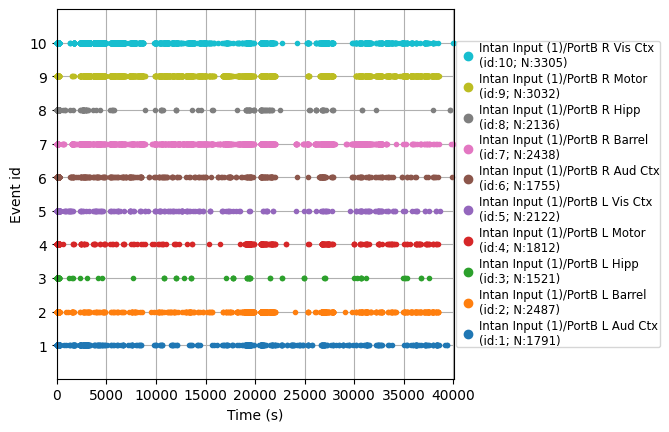

In [18]:
logger.setLevel(logging.WARNING)
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)